# Data Load And Analysis

In [30]:
# Everytime reload the notebook, reload the modules
%load_ext autoreload
%autoreload 2

# Data load and split

import pandas as pd
import os

split_csv = pd.read_csv("data/CelebA1/Eval/list_eval_partition.csv", sep=" ")

train_csv = split_csv[split_csv["split_id"] == 0]
test_csv = split_csv[split_csv["split_id"] == 1]
val_csv = split_csv[split_csv["split_id"] == 2]

print(train_csv.head(10))

image_dir = "data/CelebA1/Img/img_align_celeba"

train_img_paths = train_csv["file_name"].apply(lambda x: os.path.join(image_dir, x))
test_img_paths = test_csv["file_name"].apply(lambda x: os.path.join(image_dir, x))
val_img_paths = val_csv["file_name"].apply(lambda x: os.path.join(image_dir, x))

# convert to list
train_img_paths = train_img_paths.tolist()
test_img_paths = test_img_paths.tolist()
val_img_paths = val_img_paths.tolist()

print(len(train_img_paths))
print(len(test_img_paths))
print(len(val_img_paths))

# compute porportion of each class
prop = split_csv["split_id"].value_counts(normalize=True)

print(prop)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
    file_name  split_id
0  000001.jpg         0
1  000002.jpg         0
2  000003.jpg         0
3  000004.jpg         0
4  000005.jpg         0
5  000006.jpg         0
6  000007.jpg         0
7  000008.jpg         0
8  000009.jpg         0
9  000010.jpg         0
162770
19867
19962
split_id
0    0.803410
2    0.098530
1    0.098061
Name: proportion, dtype: float64


In [31]:
# Load datasets
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from my_dataset import CustomImageDataset

BATCH_SIZE = 256
IMG_SIZE = (64, 64)

transform = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize to [-1, 1] for tanh activation
])



train_dataset = CustomImageDataset(train_img_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = CustomImageDataset(val_img_paths, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = CustomImageDataset(test_img_paths, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(len(train_dataset), len(train_loader), len(train_loader)*BATCH_SIZE)


162770 636 162816


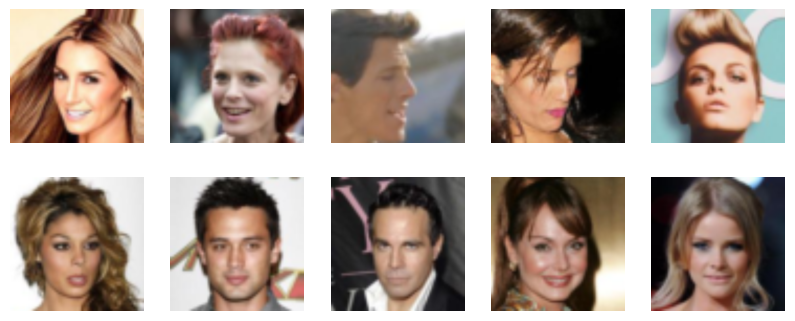

In [32]:
# Show example of images
import matplotlib.pyplot as plt

inv_transform = transforms.Compose([
    # denormalize
    transforms.Lambda(lambda x: (x * 0.5) + 0.5),
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
])

# show image in 2*5 grid
plt.figure(figsize=(10, 4))

for i, image in enumerate(train_dataset):
    if i == 10:
        break
    img = inv_transform(image)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [33]:
# build vanilla VAE
%reload_ext autoreload
%autoreload 2

from models.vanilla_vae import VanillaVAE
import torch

LATENT_DIM = 128

vanilla_vae = VanillaVAE(in_channels=3, latent_dim=LATENT_DIM, hidden_dims=[32, 64, 128, 256, 512],image_size=IMG_SIZE)
print(vanilla_vae.flat_size)

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vanilla_vae.to(device)

2048


VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Se

In [34]:
# Build Beta-VAE 
from models.beta_vae import BetaVAE

# Training epochs
epochs = 50

LOSS_TYPE = 'Cyclical'  # 'H', 'B', 'PID', 'Cyclical'
#PID controller parameters --- IGNORE ---
EXP_KLD_LOSS = 10
# H parameters --- IGNORE ---
BETA = 10
# B parameters --- IGNORE ---
GAMMA = 20
MAX_CAPACITY = 400
# Cyclical parameters
TOTAL_STEPS = epochs * len(train_loader)
MAX_BETA = 10
RATIO = 0.6
MODE = 'linear'  # 'linear' or 'sigmoid'

# loss weights
ENABLE_PERCEPTUAL_LOSS = False
LPIPS_WEIGHT = 1.2

TVL_WEIGHT = 0

# Define hidden dimensions
HIDDEN_DIMS = [32, 64, 128, 256, 512]

beta_vae = BetaVAE(in_channels=3, loss_type=LOSS_TYPE, gamma=GAMMA, latent_dim=LATENT_DIM,
                hidden_dims=HIDDEN_DIMS, image_size=IMG_SIZE,
                beta=BETA, max_capacity=MAX_CAPACITY, exp_kld_loss=EXP_KLD_LOSS, enable_perceptual_loss=ENABLE_PERCEPTUAL_LOSS,
                lpips_weight=LPIPS_WEIGHT, tvl_weight=TVL_WEIGHT,
                total_steps=TOTAL_STEPS, max_beta=MAX_BETA, ratio=RATIO, circular_mode=MODE)
beta_vae.to(device)

/home/supercomputing/miniconda3/envs/cv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/supercomputing/miniconda3/envs/cv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


BetaVAE(
  (lpips_model): LPIPS(
    (scaling_layer): ScalingLayer()
    (net): vgg16(
      (slice1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (slice2): Sequential(
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
      )
      (slice3): Sequential(
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [35]:
# Training a VAE on CelebA
import logging
import os
import torch
from models.base import BaseVAE
from torchvision.utils import save_image
from tqdm import tqdm


def train(model:BaseVAE, train_loader, optimizer, epoch, device):
    model.train()
    
    epoch_bce_loss = 0
    epoch_kld_loss = 0
    epoch_loss = 0

    loop = tqdm(train_loader, desc=f'Train Epoch {epoch}')
    
    for batch_idx, data in enumerate(loop):
        data = data.to(device)

        optimizer.zero_grad()

        recons, inputs, mu, log_var = model.forward(data)
        loss_dict = model.loss_function(recons, inputs, mu, log_var, M_N = data.size(0)/len(train_loader.dataset), is_val=False)
        
        epoch_bce_loss += loss_dict['Reconstruction_Loss'].item()
        epoch_kld_loss += loss_dict['KLD_Loss'].item()

        loss = loss_dict['loss']
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()  

    epoch_bce_loss /= len(train_loader)
    epoch_kld_loss /= len(train_loader)
    epoch_loss /= len(train_loader)

    return epoch_loss, epoch_bce_loss, epoch_kld_loss
        

def validate(model:BaseVAE, val_loader, epoch, device, result_dir:str, train_data_len:float):
    model.eval() # 切换到评估模式 (关闭 Dropout/BatchNum 统计更新)
    val_bce_loss = 0
    val_kld_loss = 0
    val_loss = 0
    
    loop = tqdm(val_loader, desc=f'Validation Epoch {epoch}')
    with torch.no_grad(): # 验证阶段不需要计算梯度，节省显存
        for batch_idx, data in enumerate(loop):
            data = data.to(device)
            
            # 1. 前向传播
            recons, inputs, mu, log_var = model.forward(data)
            
            # 2. 计算 Loss (必须和训练时的 Loss 函数一致)
            kld_weight = data.size(0)/train_data_len  # 这里的 M_N 相当于 beta-VAE 里的 beta
            loss_dict= model.loss_function(recons, inputs, mu, log_var, M_N = kld_weight, is_val=True)
            
            val_bce_loss += loss_dict['Reconstruction_Loss'].item()
            val_kld_loss += loss_dict['KLD_Loss'].item()
            val_loss += loss_dict['loss'].item()
            
            # 3. 可视化 (只在第一个 Batch 做，避免存太多图)
            if batch_idx == 0:
                # 比较：原图 vs 重构图
                # n=8 表示显示前8张。cat 把原图和重构图上下拼起来
                comparison = torch.cat([data[:8], recons[:8]])
                save_image(comparison.cpu(), f'{result_dir}/reconstruction_{epoch}.png', nrow=8, normalize=True)
                

    val_bce_loss /= len(val_loader)
    val_kld_loss /= len(val_loader)
    val_loss /= len(val_loader)
    
    # Random sampling
    with torch.no_grad():
        z = torch.randn(8, model.latent_dim).to(device)
        sample = model.decode(z)
        save_image(sample.cpu(), f'{result_dir}/sample_{epoch}.png', nrow=8, normalize=True)

    return val_loss, val_bce_loss, val_kld_loss
    

In [36]:
# Training model
from torch import optim
import logging
# Scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
# 🚀 开启 TF32 加速 (只需这一行)
# torch.set_float32_matmul_precision('high')

model = beta_vae

# compile model for faster training (optional, requires PyTorch 2.0+)
# model = torch.compile(model)

MODEL_NAME = "beta_vae"

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5)

train_bce_losses = []
train_kld_losses = []
train_losses = []
val_bce_losses = []
val_kld_losses = []
val_losses = []


best_val_bce_loss = float('inf')
no_improvement = 0
early_stopping_patience = 100
early_epoch = 10

# create results directory
result_dir = f"results_{MODEL_NAME}_ImSize{IMG_SIZE[0]}_Lat{LATENT_DIM}"
if ENABLE_PERCEPTUAL_LOSS:
    result_dir += f"_TVL{int(TVL_WEIGHT*1e4)}_LPIPS{int(LPIPS_WEIGHT*10)}"
result_dir +=f"_{LOSS_TYPE}"
if LOSS_TYPE == 'H':
    result_dir += f"_Beta{BETA}"
elif LOSS_TYPE == 'B':
    result_dir += f"_G{GAMMA}_C{MAX_CAPACITY}"
elif LOSS_TYPE == 'PID':
    result_dir += f"_EXP{EXP_KLD_LOSS}"
elif LOSS_TYPE == 'Cyclical':
    result_dir += f"_MaxBeta{MAX_BETA}_Ratio{int(RATIO*100)}_{MODE}"
os.makedirs(result_dir, exist_ok=True)

start_epoch = 0

# Load existing model if any
import os
model_path = f"{result_dir}/last_{MODEL_NAME}.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    # get the epoch from samples images names
    sample_files = [f for f in os.listdir(result_dir) if f.startswith("sample_") and f.endswith(".png")]
    if sample_files:
        sample_epochs = [int(f.split("_")[1].split(".")[0]) for f in sample_files]
        start_epoch = max(sample_epochs) + 1
    logging.info(f"Loaded existing model from {model_path}")

logging.basicConfig(level=logging.INFO)
logging.info("Training started")



for epoch in range(start_epoch, epochs):
    train_loss, train_bce_loss, train_kld_loss = train(model, train_loader, optimizer, epoch, device)
    train_bce_losses.append(train_bce_loss)
    train_kld_losses.append(train_kld_loss)
    train_losses.append(train_loss)
    
    logging.info(f"Epoch {epoch}, Train BCE Loss: {train_bce_loss:.4f}, Train KLD Loss: {train_kld_loss:.4f}, Train Loss: {train_loss:.4f}")
    
    val_loss, val_bce_loss, val_kld_loss = validate(model, val_loader, epoch, device, result_dir, len(train_dataset))
    val_bce_losses.append(val_bce_loss)
    val_kld_losses.append(val_kld_loss)
    scheduler.step(val_loss)
    val_losses.append(val_loss)

    logging.info(f"Epoch {epoch}, Val BCE Loss: {val_bce_loss:.4f}, Val KLD Loss: {val_kld_loss:.4f}, Val Loss: {val_loss:.4f}")


    if epoch < early_epoch:
        continue
    if val_bce_loss < best_val_bce_loss:
        best_val_bce_loss = val_bce_loss
        no_improvement = 0
        # save model
        torch.save(model.state_dict(), f"{result_dir}/best_{MODEL_NAME}.pth")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            logging.info(f"Early stopping at epoch {epoch}")
            break

# save model
torch.save(model.state_dict(), f"{result_dir}/last_{MODEL_NAME}.pth")

logging.info(f"Training Finished")


INFO:root:Loaded existing model from results_beta_vae_ImSize64_Lat128_Cyclical_MaxBeta10_Ratio60_linear/last_beta_vae.pth
INFO:root:Training started
Train Epoch 21: 100%|██████████| 636/636 [01:25<00:00,  7.46it/s]
INFO:root:Epoch 21, Train BCE Loss: 0.0621, Train KLD Loss: 37.4907, Train Loss: 0.0765
Validation Epoch 21: 100%|██████████| 78/78 [00:10<00:00,  7.61it/s]
INFO:root:Epoch 21, Val BCE Loss: 0.0620, Val KLD Loss: 28.8691, Val Loss: 0.0861
Train Epoch 22: 100%|██████████| 636/636 [01:22<00:00,  7.71it/s]
INFO:root:Epoch 22, Train BCE Loss: 0.0659, Train KLD Loss: 23.6516, Train Loss: 0.0949
Validation Epoch 22: 100%|██████████| 78/78 [00:10<00:00,  7.79it/s]
INFO:root:Epoch 22, Val BCE Loss: 0.0717, Val KLD Loss: 19.4841, Val Loss: 0.1042
Train Epoch 23: 100%|██████████| 636/636 [01:22<00:00,  7.71it/s]
INFO:root:Epoch 23, Train BCE Loss: 0.0758, Train KLD Loss: 17.1064, Train Loss: 0.1111
Validation Epoch 23: 100%|██████████| 78/78 [00:10<00:00,  7.78it/s]
INFO:root:Epoch 23

In [37]:
# save training and validation losses
import pandas as pd
loss_df = pd.DataFrame({
    "train_loss": train_losses,
    "train_bce_loss": train_bce_losses,
    "train_kld_loss": train_kld_losses,
    "val_loss": val_losses,
    "val_bce_loss": val_bce_losses,
    "val_kld_loss": val_kld_losses,
})
loss_df.to_csv(f"{result_dir}/losses.csv", index=False)

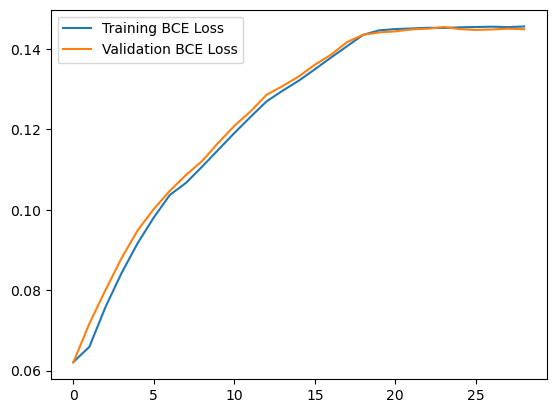

In [38]:
# Visulization Losses
import matplotlib.pyplot as plt
plt.plot(train_bce_losses, label='Training BCE Loss')
plt.plot(val_bce_losses, label='Validation BCE Loss')

plt.legend()
plt.savefig(f"{result_dir}/bce_loss_curve.png")
plt.show()

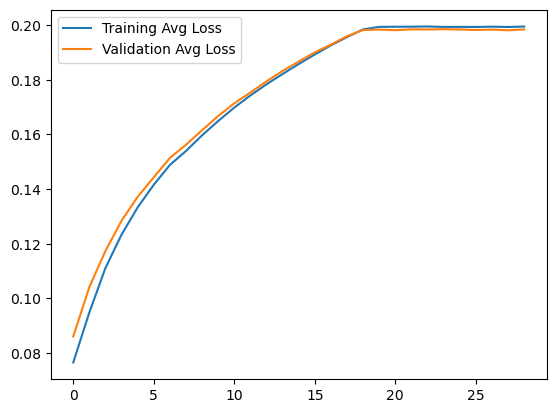

In [39]:
plt.plot(train_losses, label='Training Avg Loss')
plt.plot(val_losses, label='Validation Avg Loss')
plt.legend()
# save figure
plt.savefig(f"{result_dir}/avg_loss_curve.png")
plt.show()

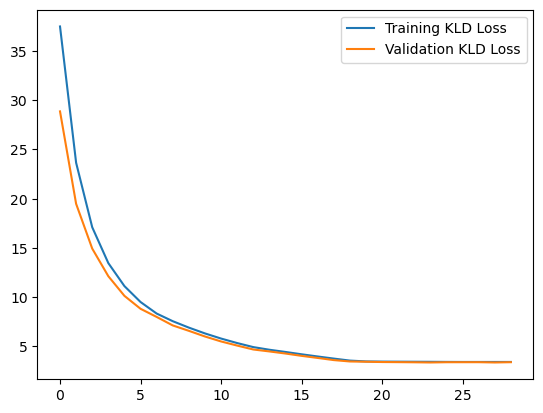

In [40]:
# reverse kld loss
plt.plot(train_kld_losses, label='Training KLD Loss')
plt.plot(val_kld_losses, label='Validation KLD Loss')
plt.legend()
# save figure
plt.savefig(f"{result_dir}/kld_loss_curve.png")
plt.show()



In [41]:
# Analyze the latent space
# 假设 model 是你的 VAE，test_loader 是验证数据
model = beta_vae
model.eval()
data = next(iter(test_loader))# 取一个 Batch
data = data.to(device)

print(data.shape)

with torch.no_grad():
    mu, log_var = model.encode(data) # 获取 mu 和 logvar
    
    # 计算每一维的平均 KLD (注意这里 dim=0，保留 dim=1 的 256 个维度)
    # 公式: -0.5 * mean(1 + logvar - mu^2 - exp(logvar))
    kld_per_dim = -0.5 * torch.mean(1 + log_var - mu ** 2 - log_var.exp(), dim=0)

    print(f"Max KLD in a dimension: {kld_per_dim.max().item():.4f}")
    print(f"Min KLD in a dimension: {kld_per_dim.min().item():.4f}")
    
    # 统计有多少个“活跃”维度 (阈值设为 0.1)
    active_dims = (kld_per_dim > 0.1).sum().item()
    print(f"Active Dimensions (>0.1): {active_dims} / {model.latent_dim}")

    # 统计有多少个死亡维度 (阈值设为 0.01)
    dead_dims = (kld_per_dim < 0.01).sum().item()
    print(f"Dead Dimensions (<0.01): {dead_dims} / {model.latent_dim}")

torch.Size([256, 3, 64, 64])
Max KLD in a dimension: 1.2891
Min KLD in a dimension: 0.0000
Active Dimensions (>0.1): 6 / 128
Dead Dimensions (<0.01): 117 / 128
